# Проблема переобучения и регуляризация моделей

In [1]:
# Подключение библиотек
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

## Проблема переобучения моделей
Будем рассматривать проблему переобучения модели линейной регрессии на примере одной из конкурсных задач, представленных на платформе Kaggle.
В учебных целях используется немного упрощенная постановка задачи.

Имеются данные (по дням) о погодных условиях и количестве велосипедов, выданных в аренду автоматизированными пунктами проката. Данные содержатся в файле *BikesRent.csv*

Требуется получить прогноз спроса (по дням) на велосипеды, выдаваемые в прокат.  

[Описание задачи](https://www.kaggle.com/c/bike-sharing-demand)

[Описание набора данных](https://www.kaggle.com/c/bike-sharing-demand/data)

### Первичное изучение набора данных

Импортируем набор данных и изучим имеющиеся признаки.

Настоятельно рекомендуется ознакомиться с описанием признаков по ссылке выше.

In [2]:
data = pd.read_csv('/content/BikesRent.csv')
data.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


In [3]:
data.shape

(731, 13)

**cnt** - прогнозируемый (выходной) признак - количество велосипедов, востребованных в течение дня;

остальные признаки - входные.

Некоторые из признаков (**season**, **mnth**, **weathersit**) изначально (по своей природе) являются категориальными; но, поскольку на множестве их значений задан порядок, то в первом приближении будем работать с ними, как с количественными.

Бинарные признаки (**holiday**, **workingday**) также будем рассматривать как количественные.

Исследуем наличие зависимостей между признаками.

Сначала выполним визуализацию попарных распределений.

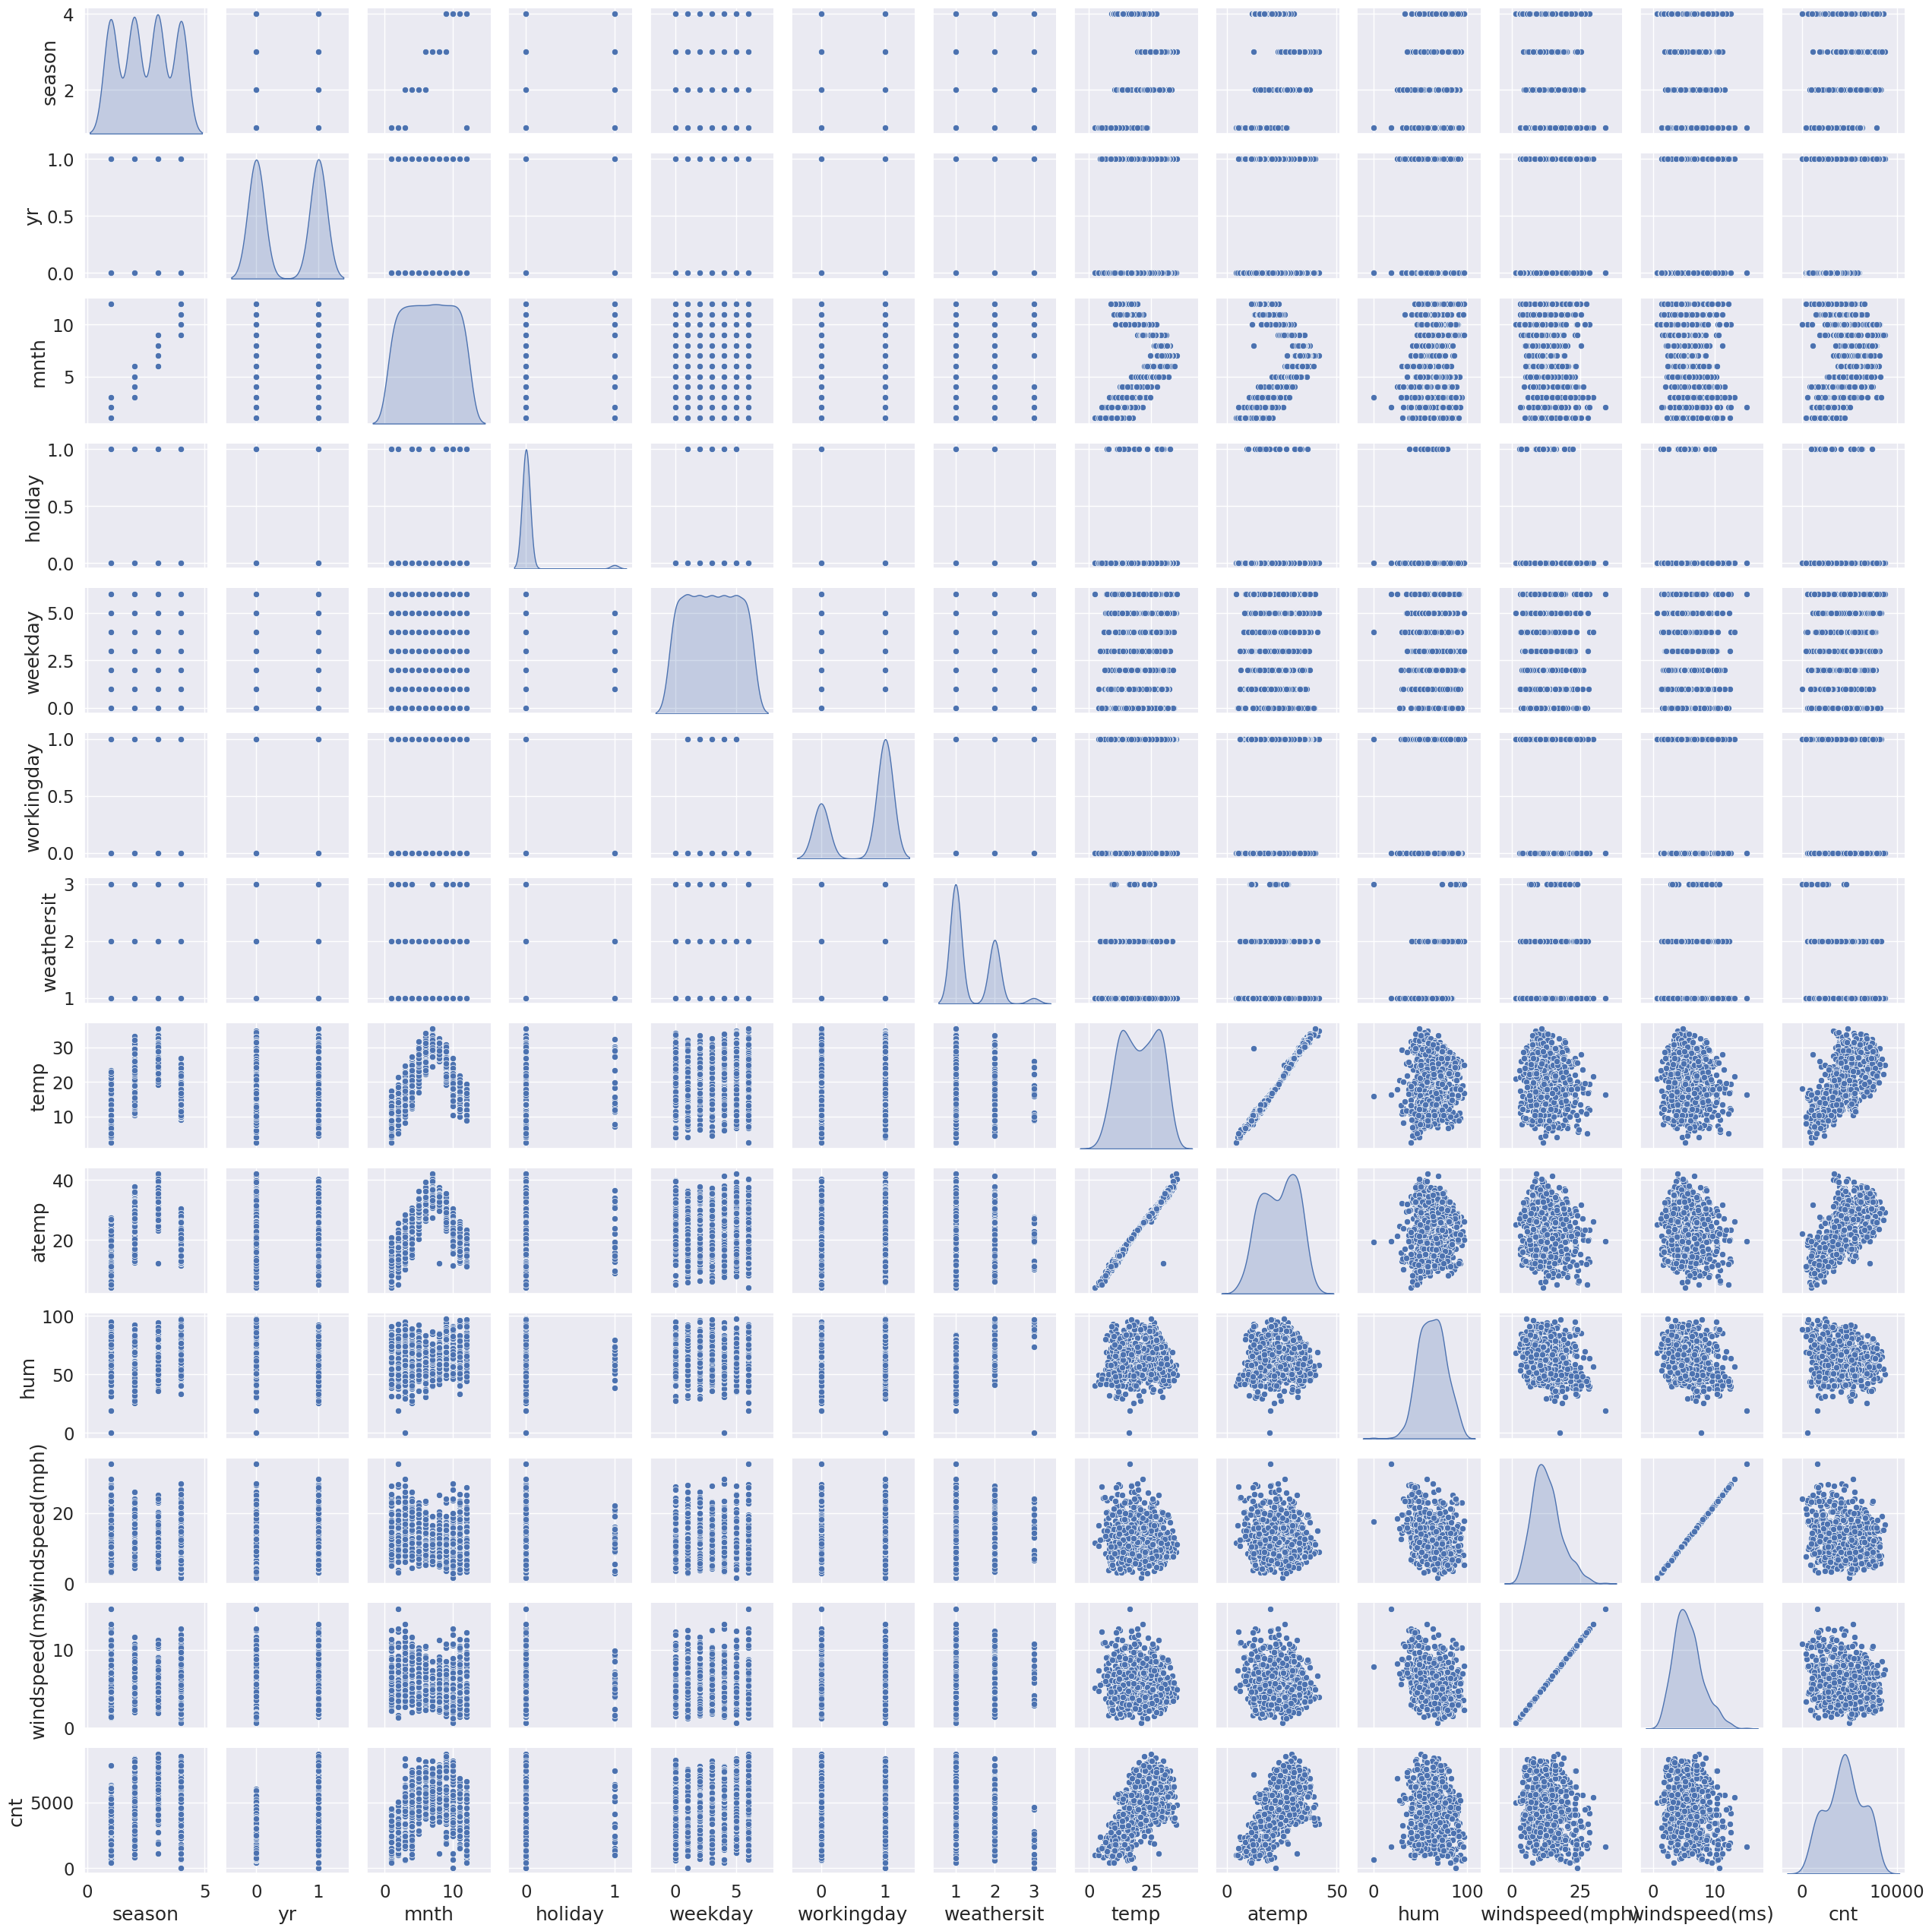

In [4]:
sns.set(font_scale=1.5)
sns.pairplot(data, diag_kind='kde', height = 2)

По диаграммам рассеяния можно заметить:

*   зависимость целевого признака **cnt** от некоторых из входных признаков (**temp**, **atemp**) близка к линейной (с рассеянием);
*   между некоторыми входными признаками наблюдается ярко выраженная линейная зависимость (**temp** и **atemp**, **windspeed(mph)** и **windspeed(ms)**).

Для более строгой оценки наличия линейных связей рассчитаем корреляционную матрицу, используя корреляцию Пирсона (установлена по умолчанию).

In [5]:
data.corr()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
season,1.000000,-0.001844,0.831440,-0.010537,-0.003080,0.012485,0.019211,0.334315,0.342876,0.205445,-0.229046,-0.229046,0.406100
yr,-0.001844,1.000000,-0.001792,0.007954,-0.005461,-0.002013,-0.048727,0.047604,0.046106,-0.110651,-0.011817,-0.011817,0.566710
mnth,0.831440,-0.001792,1.000000,0.019191,0.009509,-0.005901,0.043528,0.220205,0.227459,0.222204,-0.207502,-0.207502,0.279977
holiday,-0.010537,0.007954,0.019191,1.000000,-0.101960,-0.253023,-0.034627,-0.028556,-0.032507,-0.015937,0.006292,0.006292,-0.068348
weekday,-0.003080,-0.005461,0.009509,-0.101960,1.000000,0.035790,0.031087,-0.000170,-0.007537,-0.052232,0.014282,0.014282,0.067443
workingday,0.012485,-0.002013,-0.005901,-0.253023,0.035790,1.000000,0.061200,0.052660,0.052182,0.024327,-0.018796,-0.018796,0.061156
weathersit,0.019211,-0.048727,0.043528,-0.034627,0.031087,0.061200,1.000000,-0.120602,-0.121583,0.591045,0.039511,0.039511,-0.297391
temp,0.334315,0.047604,0.220205,-0.028556,-0.000170,0.052660,-0.120602,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.342876,0.046106,0.227459,-0.032507,-0.007537,0.052182,-0.121583,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.205445,-0.110651,0.222204,-0.015937,-0.052232,0.024327,0.591045,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659


Можно отдельно изучить корреляцию между выходным и каждым из входных признаков.

In [6]:
data.iloc[:, :12].corrwith(data['cnt'])

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64

#### Промежуточные выводы
*  Среди признаков набора данных есть входные признаки, коррелирующие с целевым. Следовательно, можно попытаться описать искомую зависимость с помощью линейной модели.
*  Среди входных признаков есть сильно коррелирующие между собой.

### Проблема коллинеарности признаков
В наборе данных имеется две пары входных признаков с высокой корреляцией:
*  windspeed(mph) и windspeed(ms) - одна и та же физическая величина (скорость ветра), выраженная в разных единицах измерения;
*  temp и atemp - одна и та же физическая величина (температура) в абсолютном значении и по субъективным ощущениям.

Далее проиллюстрируем, к каким последствиям приведет обучение линейной модели на данных, содержащих подобные проблемы.

Прежде, чем создавать модель, изучим масштаб значений признаков.

Выведем средние значения по каждому столбцу.

In [7]:
data.mean()

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Видно, что признаки имеют разный масштаб, поэтому перед обучением модели имеет смысл выполнить масштабирование данных.

Данные в наборе упорядочены по времени. Поскольку рассматривается задача не моделирования временнОго ряда, а построения модели прогнозирования на основе признакового описания объектов, необходимо выполнить перемешивание данных.

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

In [9]:
data_shuffled = shuffle(data, random_state=42)        # Создание набора данных с перемешанными записями (строками)

# Масштабирование входных признаков в наборе с перемешанными записями
scaler = StandardScaler()
X = scaler.fit_transform(data_shuffled.iloc[:, :12])  # Сохранение в отдельном объекте масштабированных значений
y = data_shuffled['cnt']                              # Сохранение в отдельном объекте значений выходного признака

Теперь можно приступить к созданию модели.

Создадим и обучим простейшую модель линейной регрессии.

In [10]:
from sklearn.linear_model import LinearRegression

In [11]:
model = LinearRegression()
model.fit(X, y)      # Обучение модели на всех имеющихся данных

LinearRegression()

In [12]:
# Вывод коэффициентов обученной модели
model.coef_

array([ 5.70863796e+02,  1.02196538e+03, -1.41301745e+02, -8.67593446e+01,
        1.37225064e+02,  5.63918818e+01, -3.30226462e+02,  3.67483733e+02,
        5.85549386e+02, -1.45614306e+02,  1.24571384e+13, -1.24571384e+13])

По результатам обучения все веса получили немаленькие значения, но особое внимание следует обратить на последние 2 коэффициента.

Сопоставим веса с названиями соответствующих признаков.

In [13]:
pairs = zip(data_shuffled.columns[:12], model.coef_)
lst = [pair for pair in pairs]    # формирование списка для вывода на печать
print(lst)

[('season', 570.8637960129914), ('yr', 1021.9653779400622), ('mnth', -141.3017451148728), ('holiday', -86.7593446245368), ('weekday', 137.22506441350538), ('workingday', 56.391881775973005), ('weathersit', -330.2264620440312), ('temp', 367.48373260182126), ('atemp', 585.5493861188597), ('hum', -145.61430569885857), ('windspeed(mph)', 12457138390688.885), ('windspeed(ms)', -12457138390887.346)]


Видим, что признаки с сильной корреляцией (windspeed(mph) и windspeed(ms)) получили огромные веса.

Это означает, что самое незначительное изменение скорости ветра приведет к изменению вклада соответствующих слагаемых в прогноз спроса во много раз. Ясно, что подобная модель непригодна для практического использования.

Для понимания, откуда берутся большие значения весов, полезно вспомнить формулу аналитического решения задачи минимизации квадратичной ошибки линейной модели:
$$ \bar w_* = (X^TX)^{-1} X^T y .$$

Если в матрице $X$ есть коллинеарные (линейно-зависимые) столбцы, то определитель матрицы $X^TX$ может стать либо близким к нулю, либо, наоборот, получить огромное значение. В обоих случаях решение задачи становится неустойчивым.

Чем более зависимы признаки, тем хуже аппроксимация $X \cdot \bar w \approx y$.

Это так называемая ***проблема мультиколлинеарности признаков***.

Проиллюстрируем это на рассматриваемом примере.

In [14]:
XT_X = np.dot(X.T, X)   # Вычисление матрицы XT*X
np.linalg.det(XT_X)     # Вычисление определителя XT*X

4.683850931927555e+16

Определитель матрицы $X^TX$ имеет очень большое значение, поэтому матрица $(X^TX)^{-1}$, хотя и будет существовать, но будет почти вырожденной:

In [15]:
X1 = np.linalg.inv(XT_X)   # Вычисление матрицы, обратной к XT*X
np.linalg.det(X1)          # Вычисление определителя обратной матрицы

2.667180480935913e-17

В такой ситуации самые незначительные изменения во входных данных могут привести к колоссальным изменениям как самой модели, так и получамых прогнозов.

**Вывод**: при построении моделей следует внимательно изучать входные признаки и, по возможности, избавляться от коллинеарности.

Однако, этот подход не всегда реализуем на практике. Количество входных признаков может измеряться сотнями, да и линейная зависимость может быть не столь очевидной.

Решением проблемы является применение ***регуляризации*** моделей.

## Регуляризация линейных моделей
Основная идея регуляризации - введение "штрафа" за большие веса, т. е. мимнимизация не самой функции ошибки  $Q(\bar w, X)$, а функции, полученной добавлением к  $Q(\bar w, X)$ ***регуляризатора***.

### $L_2$-регуляризация (Ridge)
В качестве регуляризатора используется квадрат $L_2$- нормы (евклидовой нормы) вектора весов:
$\| \bar{w} \|_2^2 = \sum_{j=1}^d w_j^2 , \;$ и вместо задачи
   $$Q(\bar w, X) \; \to \; \min\limits_{\bar w} \; \quad \quad (*)$$ решается задача
  $$Q(\bar w, X) + λ \cdot \| \bar{w} \|_2^2  \; \to \; \min\limits_{\bar w} ,\; \quad \quad (**)$$
где $λ \; - $ ***коэффициент регуляризации***.

В случае квадратичной функции ошибки задача (**) имееет вид
$$ \frac 1 l \sum_{i=1}^l(⟨ \bar w, \bar x_i ⟩ - y_i)^2 \; + λ \cdot \| \bar{w} \|_2^2  \; \to \; \min\limits_{\bar w} . $$

При таком подходе алгоритм минимизации будет стремиться уменьшить всю сумму, включая и слагаемое $λ \cdot \| \bar{w} \|_2^2 ,$ что приведет к ограничению роста значений $w_j .$

При использовании $L_2$-регуляризатора аналитическое решение задачи будет иметь вид:
$$\bar w_* = (X^T \cdot X + λ \cdot I)^{-1} \cdot X^T \cdot \bar y \;, $$
где $I-$единичная матрица.

Задача регрессии с $L_2$-регуляризацией получила название ***гребневой регрессии (Ridge regression)*** (Ridge - гребень (англ.) ).

Важное свойство $L_2$-регуляризации: функция ошибки - гладкая выпуклая функция, поэтому задача хорошо решается градиентными методами.

### $L_1$-регуляризация (LASSO)
В качестве регуляризатора используется $L_1$- норма вектора весов:
$\| \bar{w} \|_1 = \sum_{j=1}^d |w_j| , \;$ и вместо задачи (\*\) решается задача
 $$Q(\bar w, X) + λ \cdot \| \bar{w} \|_1  \; \to \; \min\limits_{\bar w} ,\; \quad \quad (***)$$
где $λ \; - $ ***коэффициент регуляризации***.

В случае квадратичной функции ошибки задача (***) имеет вид
$$ \frac 1 l \sum_{i=1}^l(⟨ \bar w, \bar x_i ⟩ - y_i)^2 \; + λ \cdot \| \bar{w} \|_1  \; \to \; \min\limits_{\bar w} . $$

Задача регрессии с $L_1$-регуляризацией получила название ***LASSO*** (***Least Absolute Shrinkage and Selection Operator***).

Cвойство $L_1$-регуляризации: функция ошибки не является гладкой, поэтому для решения задачи нельзя применять градиентные методы.
Вместе с тем, у $L_1$-регуляризатора есть полезная особенность, которая будет проиллюстрирована ниже.

**О коэффициенте регуляризации**:

его значение подбирается индивидуально в каждой конкретной задаче.

Оно должно быть не слишком большим (чтобы не допустить обнуления большинства или даже всех весов), но и не слишком маленьким (чтобы не допустить переобучения).

### Реализация регуляризаторов в библиотеке Scikit-learn

*  Методы работы с моделями линейной регрессии с $L_2$-регуляризацией  реализованы в классе **Ridge** модуля **linear_model**.

[Документация класса Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge)

*  Методы работы с моделями линейной регрессии с $L_1$-регуляризацией  реализованы в классе **Lasso** модуля **linear_model**.

[Документация класса Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso)


Основные приемы построения моделей и получения прогнозов те же, которые использовались в классе **LinearRegression**.

Параметр, определяющий значение коэффициента регуляризации, в обоих классах называется **alpha**.

Проиллюстрируем применение регуляризаторов на примере рассмотренной выше задачи прогнозирования спроса на велосипеды.

In [16]:
from sklearn.linear_model import Lasso, Ridge

In [17]:
model_ridge =  Ridge()  # создание экземпляра класса Ridge с параметрами по умолчанию
model_ridge.fit(X, y)   # Обучение модели на всех имеющихся данных

Ridge()

In [18]:
# Вывод коэффициентов обученной модели
model_ridge.coef_

array([ 563.06457225, 1018.94837879, -131.87332028,  -86.746098  ,
        138.00511118,   55.90311038, -332.3497885 ,  386.45788919,
        566.34704706, -145.0713273 ,  -99.25944108,  -99.25944115])

In [19]:
pairs_ridge = zip(data_shuffled.columns[:12], model_ridge.coef_)
lst_r = [pair for pair in pairs_ridge]    # формирование списка для вывода на печать
print(lst_r)

[('season', 563.0645722520181), ('yr', 1018.9483787875305), ('mnth', -131.87332028247715), ('holiday', -86.74609799709232), ('weekday', 138.00511117871918), ('workingday', 55.90311037506467), ('weathersit', -332.34978849907367), ('temp', 386.45788919190807), ('atemp', 566.3470470600669), ('hum', -145.07132729867195), ('windspeed(mph)', -99.25944108179067), ('windspeed(ms)', -99.25944115434177)]


In [20]:
model_lasso =  Lasso()  # создание экземпляра класса Lasso с параметрами по умолчанию
model_lasso.fit(X, y)   # Обучение модели на всех имеющихся данных

Lasso()

In [21]:
# Вывод коэффициентов обученной модели
model_lasso.coef_

array([ 5.60241616e+02,  1.01946349e+03, -1.28730627e+02, -8.61527813e+01,
        1.37347894e+02,  5.52123706e+01, -3.32369857e+02,  3.76363236e+02,
        5.76530794e+02, -1.44129155e+02, -1.97139689e+02, -2.80514042e-08])

In [22]:
pairs_lasso = zip(data_shuffled.columns[:12], model_lasso.coef_)
lst_l = [pair for pair in pairs_lasso]    # формирование списка для вывода на печать
print(lst_l)

[('season', 560.2416160308861), ('yr', 1019.4634940657196), ('mnth', -128.73062703678696), ('holiday', -86.15278133371106), ('weekday', 137.34789390496314), ('workingday', 55.21237064135668), ('weathersit', -332.3698569623487), ('temp', 376.3632362096943), ('atemp', 576.530793504555), ('hum', -144.12915500348583), ('windspeed(mph)', -197.1396894024843), ('windspeed(ms)', -2.8051404183533485e-08)]


Как видим, применение обоих типов регуляризации (даже без специального подбора параметров) позволяет решить проблему больших весов.

Самостоятельно: сопоставьте веса всех остальных (кроме windspeed(mph) и windspeed(ms) ) признаков, полученные в результате обучения всех трех моделей: без регуляризации и с двумя типами регуляризаторов.

### Проблема неинформативных признаков
Полезное свойство  $L_1$-регуляризатора - способность выполнять отбор наиболее значимых признаков:

> после применения  $L_1$-регуляризации с хорошо подобранным коэффициентом веса малозначимых признаков становятся равными нулю (или близкими к нулю).

Проиллюстрируем это на примере рассматриваемой задачи.

In [23]:
alphas = np.arange(1, 500, 50)  # Массив значений коэффициента регуляризации

In [24]:
# Списки значений весов моделей, полученных после обучения с разными значениями коэффициента регуляризации
coefs_lasso = []
coefs_ridge = []

In [25]:
# Обучение моделей с разными значениями коэффициента регуляризации и сохранение полученных весов вложенными списками
for al in alphas:
  model_r = Ridge(alpha=al)  # создание экземпляра класса Ridge с текущим значением коэффициента регуляризации
  model_r.fit(X, y)          # обучение модели на всех имеющихся данных
  coefs_ridge.append(list(model_r.coef_))  # добавление полученных весов к общему списку (вложенным списком)
  model_l = Lasso(alpha=al)  # создание экземпляра класса Lasso с текущим значением коэффициента регуляризации
  model_l.fit(X, y)          # обучение модели на всех имеющихся данных
  coefs_lasso.append(list(model_l.coef_))  # добавление полученных весов к общему списку (вложенным списком)
coefs_ridge = np.array(coefs_ridge)
coefs_lasso = np.array(coefs_lasso)
print('Ridge:\n', coefs_ridge)
print('Lasso:\n', coefs_lasso)

Ridge:
 [[ 563.06457225 1018.94837879 -131.87332028  -86.746098    138.00511118
    55.90311038 -332.3497885   386.45788919  566.34704706 -145.0713273
   -99.25944108  -99.25944115]
 [ 461.1786324   954.30774189  -41.56545001  -84.91347027  126.60366663
    54.2516911  -313.27515141  458.90147709  481.44350031 -151.29101033
  -101.62731482 -101.62731483]
 [ 403.97653045  898.08362212    5.67424346  -81.91106159  117.94141144
    52.72848389 -298.40898086  455.28986839  467.43141748 -152.68605059
  -102.10167084 -102.10167084]
 [ 366.60423851  848.46346471   34.02728278  -78.77196479  110.68012006
    51.25719208 -286.12515935  447.47982533  455.75402966 -151.48320603
  -102.00537592 -102.00537593]
 [ 339.74528956  804.25104797   52.48987295  -75.71740756  104.40346414
    49.84189502 -275.48609488  438.50968939  444.7642744  -148.94396978
  -101.58638458 -101.58638458]
 [ 319.15864133  764.5614337    65.15200737  -72.81970821   98.87880449
    48.4845255  -266.00255564  429.21412336  4

Легко видеть, что применение Lasso с достаточно большим коэффициентом регуляризации приводит к обнулению весов малозначимых признаков. Применение Ridge не дает такого эффекта.

❓ **Упражнение**: самостоятельно сопоставьте процесс обнуления весов с полученными ранее коэффициентами корреляции входных и прогнозируемого признака. Сформулируйте выводы.

Визуализируем зависимость весов признаков, полученных после обучения моделей, от величины коэффициента регуляризации.

Text(0.5, 1.0, 'Lasso')

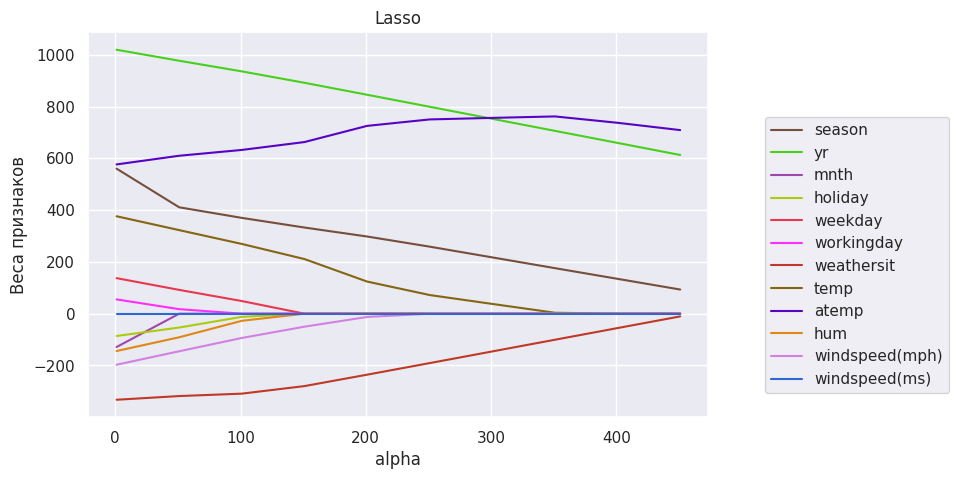

In [26]:
sns.set(font_scale=1)
np.random.seed(35)
plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_lasso.T, data_shuffled.columns[:12]):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.8))
plt.xlabel("alpha")
plt.ylabel("Веса признаков")
plt.title("Lasso")

Text(0.5, 1.0, 'Ridge')

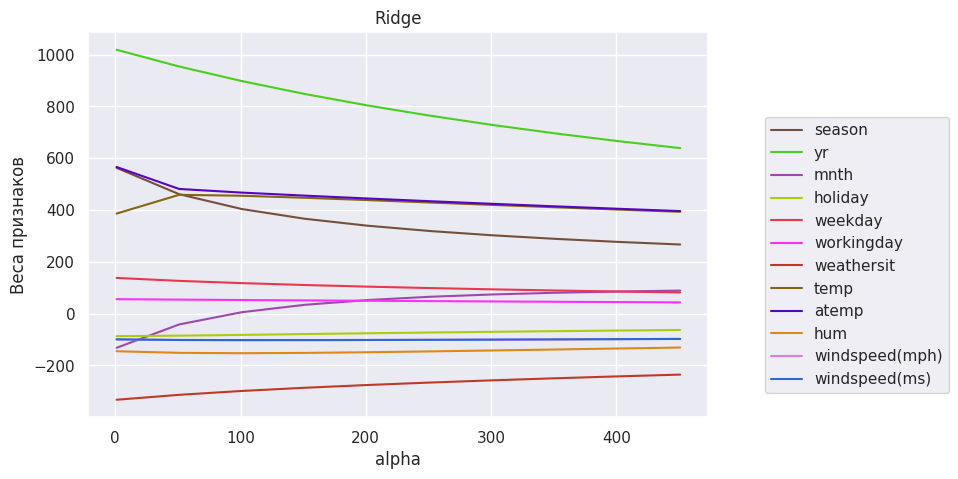

In [27]:
np.random.seed(35)
plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, data_shuffled.columns[:12]):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.8))
plt.xlabel("alpha")
plt.ylabel("Веса признаков")
plt.title("Ridge")

❓ **Упражнение**: проанализируйте полученные графики. Сформулируйте выводы.

### Подбор коэффициента регуляризации
Как уже было сказано, оптимальное значение коэффициента регуляризации подбирается под конкретную задачу; значение $λ ,$ дающее хороший результат на одних данных, может оказаться крайне неудачным для других.

Для оценки качества моделей пока будем продолжать использовать среднеквадратичную ошибку (MSE).

В библиотеке **Scikit-learn** имеется удобный инструментарий для подбора коэффициента регуляризации, обеспечивающего наименьшее значение функции ошибки.

Для примера рассмотрим класс **LassoCV** из модуля **linear_model**.

При создании модели-экземпляра класса можно указать список или массив (объект *array-like*) значений коэффициента регуляризации - через параметр **alphas**. После применения метода **fit()** для каждого значения из **alphas** будет обучена модель Lasso с текущим коэффициентом регуляризации.

Для оценки качества всех обученных моделей применяется ***кросс-валидация*** (более "продвинутая" схема по сравнению с однократным разбиением данных на обучающие и тестовые):
*   выполняется разбиение набора данных на $K$ блоков (*folds*),
*   один из блоков используется в качестве тестовой (отложенной) выборки; на остальных данных модель обучается;
*   процедура повторяется для каждого из $K$ блоков.

Для получения итоговой оценки качества модели среднеквадратичная ошибка усредняется по всем $K$ блокам.

Такая схема позволяет избежать "подстраивания" коэффициента регуляризации под конкретные тестовые данные.

После обучения модели **LassoCV** доступны
*  значенние коэффициента регуляризации, на котором была получена минимальная ошибка - через атрибут **alpha_** ;
*  веса признаков и свободный коэффициент модели, для которой получена минимальная ошибка - через атрибуты **coef_** и **intercept_** ;
*  значения коэффициента регуляризации, для которых проводилось обучение (порядок может отличаться от того, который был указан при создании модели) - через атрибут **alphas_** ;
*  матрица значений MSE для каждого коэффициента регуляризации и каждого блока кросс-валидации - через атрибут **mse_path_**.

[Документация класса LassoCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html)

Применим этой инструментарий к рассматриваемой задаче прогнозирования спроса на велосипеды

In [28]:
from sklearn.linear_model import LassoCV

In [29]:
alphas = np.arange(1, 100, 5)            # Сетка значений коэффициента регуляризации, на которой надо делать подбор
model_l_cv = LassoCV(alphas=alphas)      # Создание экземпляра класса с заданной сеткой
model_l_cv.fit(X, y)                     # Обучение моделей на сетке

LassoCV(alphas=array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81,
       86, 91, 96]))

In [30]:
# Вывод коэффициента регуляризации, на котором получена минимальная ошибка
model_l_cv.alpha_

1

In [31]:
# Вывод коэффициентов модели с минимальной ошибкой
model_l_cv.coef_

array([ 5.60241616e+02,  1.01946349e+03, -1.28730627e+02, -8.61527813e+01,
        1.37347894e+02,  5.52123706e+01, -3.32369857e+02,  3.76363236e+02,
        5.76530794e+02, -1.44129155e+02, -1.97139689e+02, -2.80514042e-08])

In [32]:
# Свободный коэффициент модели с минимальной ошибкой
model_l_cv.intercept_

4504.3488372093025

In [33]:
# Значения коэффициента регуляризации, для которых выполнялось обучение
model_l_cv.alphas_

array([96, 91, 86, 81, 76, 71, 66, 61, 56, 51, 46, 41, 36, 31, 26, 21, 16,
       11,  6,  1])

In [34]:
# Матрица значений MSE. Размерность: (число элементов alphas, число блоков кросс-валидации)
model_l_cv.mse_path_

array([[803606.60244077, 909516.81949203, 856983.69774481,
        893284.70153213, 784856.83658029],
       [796118.34203084, 905847.38528818, 847078.75192492,
        889243.93579895, 780167.40645664],
       [788045.85818471, 902497.93487377, 837555.0977051 ,
        885455.05581608, 775858.2870176 ],
       [779824.91128332, 899469.63800282, 828407.82601459,
        881730.98413461, 771928.33698789],
       [771981.53426992, 896762.48693176, 819636.72631023,
        878240.04022018, 768378.53482014],
       [764512.76340344, 894376.4816275 , 811237.79667747,
        875060.04899288, 764915.86877383],
       [757421.54706449, 892311.62208991, 803218.86796374,
        872190.97810625, 761698.62981857],
       [750709.81352605, 890567.90831897, 795199.15309696,
        869632.80112018, 758904.02411889],
       [744376.99051045, 889145.3403147 , 787361.30180859,
        867385.49505681, 756531.9920458 ],
       [738422.95018564, 888043.91807709, 779913.59796298,
        865449.03994156

Обратите внимание на столбцы матрицы значений MSE: если выбирать минимальную ошибку для каждого блока отдельно, то для разных блоков оптимальными будут разные значения коэффициента регуляризации.

Стратегия кросс-валидации позволяет получить минимум ошибки, усредненной по всем блокам.

В данном примере мы получили, что значение $λ = 1$ достаточно для подавления эффекта переобучения; при этом дальнейшее увеличение коэффициента регуляризации приводит к излишнему упрощению модели и, как следствие - увеличению ошибки.

❓ **Упражнение**: самостоятельно дайте интерпретацию полученным весам признаков.

Соотнесите со "здравым смыслом" положительные значения весов, отрицательные, близкие к нулю.

# Еще об инструментарии построения линейных моделей с регуляризацией

Рассмотрим еще один инструмент из библиотеки **Scikit-learn**, который предоставляет широкие возможности для настройки моделей линейной регрессии.

В классе **SGDRegressor** из модуля **linear_model** реализованы дополнительные возможности по настройке моделей линейной регрессии. Обучение моделей, созданных на основе этого класса, выполняется с помощью стохастического градиентного спуска (SGD).

[Документация класса](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html)

При создании модели на основе этого класса доступны настройки:
*  функция потерь, используемая в процессе обучения модели - через параметр **loss**;
*  тип применяемого регуляризатора - через параметр **penalty**;
*  величина коэффициента регуляризации - через параметр **alpha**;
*  множество настроек для управления процессом градиентного спуска (параметры **tol**, **epsilon**, **learning_rate** и др.);
*  др.

Основные приемы построения моделей и получения прогнозов те же, которые были рассмотрены ранее для других классов.

❓ **Упражнение**: изучите документацию класса **SGDRegressor**.
Поэкспериментируйте с созданием моделей на основе этого класса (можно использовать сгенерированные модельные наборы данных либо любой из рассмотренных ранее наборов).

# Метрики качества моделей линейной регрессии

Применение метрик качества в машинном обучении:
*  задание функционала ошибки, который будет использоваться в процессе обучения модели;
*  оценивание итоговой модели (пригодна ли она для решения поставленной задачи);
*  подбор гиперпараметров модели (типа регуляризатора, коэффициента регуляризации и т. п.).

**!!!** В одной и той же задаче на разных этапах могут использоваться разные метрики. Например, обучение модели может выполняться на основе среднеквадратичной ошибки, а для итоговой оценки модели использоваться другая метрика.

## Основные метрики качества моделей регрессии

### Средняя квадратичная ошибка (Mean Squared Error, MSE)

Эта метрика уже использовалась в рассмотренных выше примерах.
$$ MSE(a, X) \; = \; \frac 1 l \sum_{i=1}^l(a( \bar x_i) - y_i)^2 \;  . $$

Основное **достоинство** этой метрики - гладкость и выпуклость функции ошибки, что гарантирует существование единственной точки минимума, которая может быть найдена с помощь градиентного спуска.

Основной **недостаток** - чувствительность к наличию выбросов в данных. Кроме того, ошибка будет измеряться в "квадратных единицах" ($руб^2, \;шт^2$ и т. п.).

### Средняя абсолютная ошибка (Mean Absolute Error, MAE)

Это способ "уйти" от возведения в квадрат.
$$ MAE(a, X) \; = \; \frac 1 l \sum_{i=1}^l|a( \bar x_i) - y_i| \;  . $$

Эта метрика менее чувствительна к выбросам в данных. При этом ошибка измеряется в тех же единицах, что и прогнозиреумая величина.

Основной **недостаток** - отсутствие гладкости функции ошибки. Следствие этого - для поиска минимума нельзя применять градиентные методы.

### Коэффициент детерминации (модификация MSE, учитывающая разброс ответов в наборе данных)

Эта метрика соотносит величину MSE с дисперсией ответов (значений прогнозируемого признака) в наборе данных.

Коэффициент детерминации вычисляется по формуле
$$ R^2(a, X) \; = \; 1 - \frac {\sum_{i=1}^l(a( \bar x_i) - y_i)^2}{\sum_{i=1}^l(y_i - \bar y)^2} \;  ,$$
где $ \; \bar y  \; = \; \frac 1 l \sum_{i=1}^ly_i \;  $.

Величина $R^2$ показывает, какую долю дисперсии (разнообразия) ответов смогла объяснить (предсказать модель).
*  Для "разумных" моделей $ \; 0 ≤ R^2 \le 1$;
*  для идеальной модели $ \; R^2 = 1$;
*  для оптимальной константной модели (для всех объектов дает прогноз - среднее по обучающей выборке $ \bar y$ ) $ \; R^2 = 0$ ;
*  $R^2 < 0$ означает, что модель хуже константной; такую модель нет смысла рассматривать.

## Реализация метрик качества в Scikit-learn

Большинство метрик, используемых в машинном обучении для оценки качества алгоритмов, имеет реализацию в модуле **metrics** библиотеки Scikit-learn.

[Документация модуля](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)

В частности,
*  метрика MSE реализована в функции **mean_squared_error()** ;
*  метрика MAE - в функции **mean_absolute_error()** ;
*  метрика $R^2$ - в функции **r2_score()** .

[Документация функции mean_squared_error()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error)

[Документация функции mean_absolute_error()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html#sklearn.metrics.mean_absolute_error)

[Документация функции r2_score()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html#sklearn.metrics.r2_score)

Все указанные функции принимают на вход 2 объекта array-like (массивы, списки или Serias):
*  список (массив) правильных ответов,
*  список (массив) предсказаний модели,

и возвращают значение соответствующей метрики.

Проиллюстрируем применение метрик для оценки качества модели прогнозирования спроса на велосипеды, полученной с помощью инструментария LassoCV.

Для получения лучшей модели в этом классе применялась кросс-валидация, поэтому будем выполнять оценку качества на всем наборе данных (без дополнительного разбиения).
Выполним построение прогноза, используя коэффициенты модели с наименьшей среднеквадратичной ошибкой по кросс-валидации.

In [35]:
# Для напоминания:
# веса модели с минимальной ошибкой
print(model_l_cv.coef_)

# свободный коэффициент модели с минимальной ошибкой
print(model_l_cv.intercept_)

[ 5.60241616e+02  1.01946349e+03 -1.28730627e+02 -8.61527813e+01
  1.37347894e+02  5.52123706e+01 -3.32369857e+02  3.76363236e+02
  5.76530794e+02 -1.44129155e+02 -1.97139689e+02 -2.80514042e-08]
4504.3488372093025


In [36]:
# Построение прогноза путем непосредственного применения уравнения регрессии
y_pred = np.dot(X, model_l_cv.coef_) + model_l_cv.intercept_
y_pred[:10]

array([6177.43353729, 1545.38869322, 2987.08282925, 4377.13997836,
       6715.45125742, 7223.63872394,  808.81778752, 2088.3506279 ,
       7173.55271529, 6399.84804006])

Заметим, что тот же результат можно получить, применив метод **predict()** к обученной ранее модели (будут использованы коэффициенты лучшей из построенных моделей).

In [37]:
# Построение прогноза с помощью predict()
model_l_cv.predict(X)[:10]

array([6177.43353729, 1545.38869322, 2987.08282925, 4377.13997836,
       6715.45125742, 7223.63872394,  808.81778752, 2088.3506279 ,
       7173.55271529, 6399.84804006])

In [38]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

Вычислим средеквадратичную ошибку на всем наборе данных

In [39]:
mean_squared_error(y_true=y, y_pred=y_pred)

748633.4132801282

Следует иметь в виду, что полученное значение найдено с использованием квадратов ошибок на объектах (измеряется в $шт^2$).

Для получения более наглядной величины можно извлечь квадратный корень из MSE (и рассматривать как ориентировочную оценку).

In [40]:
(mean_squared_error(y_true=y, y_pred=y_pred))**0.5

865.2360448340835

Вычислим среднюю абсолютную ошибку на всем наборе данных

In [41]:
mean_absolute_error(y_true=y, y_pred=y_pred)

644.9069772541344

Таким образом, видим, что средняя ошибка прогноза составляет 645 велосипедов.

При среднем значении спроса (было найдено выше), составляющем около 4504 велосипедов, не такое уж маленькое значение.

Вычислим коэффициент детерминации модели

In [42]:
r2_score(y_true=y, y_pred=y_pred)

0.800239476118262

На основе полученного значения модель вполне можно назвать "разумной",  хотя и не особенно точной

Для наглядного представления качества прогнозирования полезно выполнить визуализацию прогнозов в сравнении с правильными ответами.

Однако, в случае, когда входных признаков больше 2, визуализировать гиперплоскость в многомерном пространстве невозможно.

В таких случаях можно выполнить построение графика в координатах "правильные ответы" - "прогнозы модели".

Ясно, что в случае идеально точных предсказаний этот график будет расположен на биссектрисе первого координатного угла. Чем заметнее отличие графика от биссектрисы, тем ниже качество прогноза модели.

Text(0.5, 1.0, 'Оценка качества прогноза линейной модели')

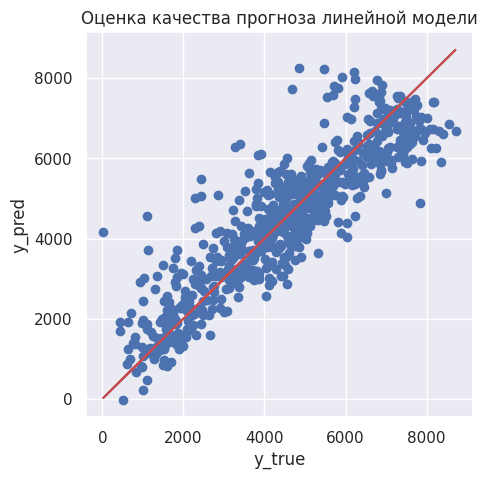

In [43]:
plt.figure(figsize=(5, 5))
plt.plot(y, y, 'r')           # биссектриса
plt.scatter(y, y_pred)        # точки (ответ, прогноз)
plt.xlabel("y_true")
plt.ylabel("y_pred")
plt.title("Оценка качества прогноза линейной модели")

Можно констатировать, что модель в целом правильно описывает зависимость спроса от имеющихся входных признаков.

Однако, следует учитывать, что оценка качества выполнялась на тех данных, которые так или иначе участвовали в обучении модели (хотя и с применением кросс-валидации).

Для получения итоговой оценки необходимо найти значения метрик на наборе данных, не участвоваших в процессе обучения.